In [1]:
%pylab inline

import pyart
import wradlib as wrl
import pandas as pd
import tempfile
import os
import pandas as pd

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

from copy import deepcopy
import boto3
from botocore.handlers import disable_signing

import datetime as dt
import pytz

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/botocore/awsrequest.py:624: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class HeadersDict(collections.MutableMapping):


In [2]:
def get_radar_field(radar):

    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_transition()
    gatefilter.exclude_masked('reflectivity')
    # Mask reflectivity
    radar.fields["corrected_reflectivity"] = deepcopy(radar.fields["reflectivity"])
    radar.fields["corrected_reflectivity"]["data"] = np.ma.masked_where(
        gatefilter._gate_excluded, radar.fields["corrected_reflectivity"]["data"])
    rr = pyart.retrieve.est_rain_rate_z(radar, refl_field="corrected_reflectivity")
    radar.add_field('rainrate',rr,replace_existing=True)
    # Mask out last 10 gates of each ray, this removes the "ring" around the radar.
    radar.fields['rainrate']['data'][:, -10:] = np.ma.masked
    
    return radar,gatefilter

In [3]:
!pwd

/gpfs/fs1/home/icrisologo/PREEVENTS/notebooks/MeltingLayer


In [4]:
filepath = "/lcrc/group/earthscience/icrisologo/DATA/nexrad/2015/01/01"

fnamelist = os.listdir(filepath)
fname = fnamelist[0]
radar = pyart.io.read(os.path.join(filepath,fname))
rad,gatefilter = get_radar_field(radar)

# Set up figure

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


'20150101_190955'

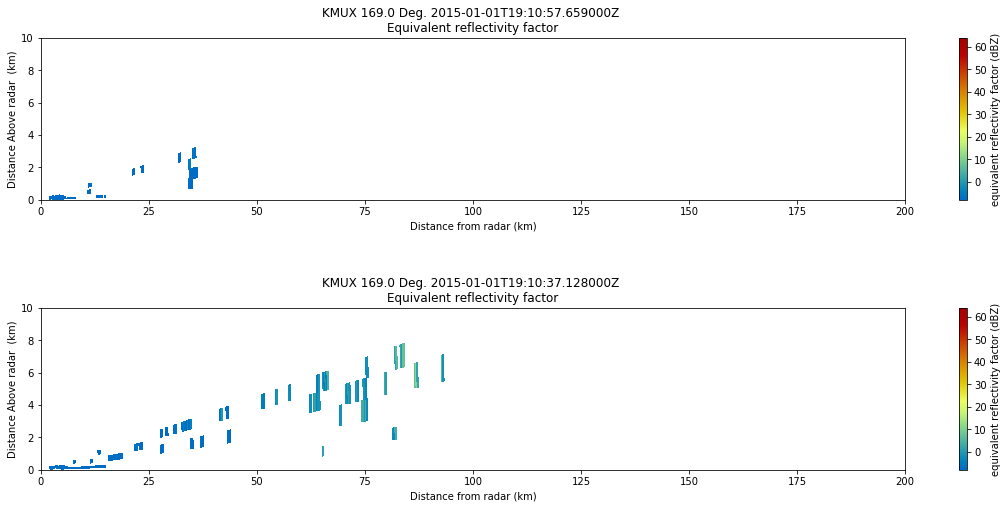

In [5]:
# Plotting
fig = plt.figure(figsize=[15,15])
rhi0_panel_axes = [0.05, 0.10, 1, .15]
rhi1_panel_axes = [0.05, 0.35, 1, .15]

# Set parameters.
vmin = -8
vmax = 64

xsect = pyart.util.cross_section_ppi(rad, [169,270.2])

# plotting RHI
display = pyart.graph.RadarDisplay(xsect)
ax3 = fig.add_axes(rhi0_panel_axes)
display.plot('reflectivity', 0, vmin=vmin, vmax=vmax)
ax4 = fig.add_axes(rhi1_panel_axes)
display.plot('reflectivity', 1, vmin=vmin, vmax=vmax)
for ax in [ax3,ax4]:
    ax.set_ylim((0,10))
    ax.set_xlim((0,200))
plt.tight_layout()

# get time info
timeobj = dt.datetime.strptime(rad.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')
dt.datetime.strftime(timeobj,'%Y%m%d_%H%M%S')

#savefname_fig = '170az_270az_RHI_'+dt.datetime.strftime(timeobj,'%Y%m%d_%H%M%S')+'.png'

In [6]:
ranges = deepcopy(radar.fields['reflectivity'])
azs = deepcopy(radar.fields['reflectivity'])

# Load the AR database to get the dates

In [7]:
ARdatafile = '/lcrc/group/earthscience/icrisologo/DATA/ARcatalog_NCEP_NEW_1948-2019.csv'

Filter the database based on year and location (altitude)

In [9]:
df = pd.read_csv(ARdatafile)

year = 1996
df_ca = df.loc[(df.Lat > 35) & (df.Lat < 40) & (df.Year == year)] # filtering location, selecting only those in central CA

Get the list of dates where AR is present.

In [10]:
ar_dates = []
for m in df_ca.Month.unique():
    df_ = df_ca.loc[(df_ca.Month == m)]
    df_start = df_.iloc[[0]]
    dstart = df_start.Day.get_values()[0]
    df_end = df_.iloc[[-1]]
    dend = df_end.Day.get_values()[0]
    start = dt.datetime(year,m,dstart)
    end = dt.datetime(year,m,dend)
    ar_dates.append([start,end])

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  """
/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  import sys


In [11]:
ar_dates[:3]

[[datetime.datetime(1996, 1, 1, 0, 0), datetime.datetime(1996, 1, 31, 0, 0)],
 [datetime.datetime(1996, 2, 4, 0, 0), datetime.datetime(1996, 2, 19, 0, 0)],
 [datetime.datetime(1996, 3, 4, 0, 0), datetime.datetime(1996, 3, 4, 0, 0)]]

In [12]:
for j in range(len(ar_dates))[:3]:
    print(j)
    d0 = ar_dates[j][0]
    d1 = ar_dates[j][1]
    td = dt.timedelta(days = 1)
    dates = np.arange(d0, d1, td).astype(dt.datetime)

    for d in dates:
        print(d)
        filepath = '/lcrc/group/earthscience/icrisologo/DATA/nexrad/'+str(d.year)+'/'+str(d.month).zfill(2)+'/'+str(d.day).zfill(2)

        fnamelist = os.listdir(filepath)
        fnamelist.sort()
        try:
            fname = fnamelist[0]
        except IndexError:
            continue
        radar = pyart.io.read(os.path.join(filepath,fname))
        rad,gatefilter = get_radar_field(radar)

        qvp_refl = []
        qvp_height = []
        qvp_time = []
        qvp_range = []

        fnamelist.sort()

        for fname in fnamelist:
            try:
                radar = pyart.io.read(os.path.join(filepath,fname))
            except TypeError:
                continue
            rad,gatefilter = get_radar_field(radar)

            qvp = pyart.retrieve.quasi_vertical_profile(rad, fields='reflectivity', desired_angle=10.0, gatefilter=gatefilter)
            timeobj = dt.datetime.strptime(qvp['time']['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')

            qvp_refl.append(qvp['reflectivity'].data)
            qvp_height.append(qvp['height'].data)
            qvp_time.append(timeobj)
            qvp_range.append(qvp['range'].data)    

        qvp_refl = np.array(qvp_refl)
        qvp_height = np.array(qvp_height)
        qvp_time = np.array(qvp_time)
        qvp_range = np.array(qvp_range)

        # create dictionary
        data = {}
        data['reflectivity'] = qvp_refl
        data['time'] = qvp_time
        data['height'] = qvp_height
        data['range'] = qvp_range

        savefname = 'qvp_10deg_'+str(timeobj.year)+str(timeobj.month).zfill(2)+str(timeobj.day).zfill(2)+'.hdf5'
        np.save(savefname, data)    

0
1996-01-01 00:00:00


FileNotFoundError: [Errno 2] No such file or directory: '/lcrc/group/earthscience/icrisologo/DATA/nexrad/1996/01/01'

In [27]:
j

6

In [28]:
fname

'KMUX20151215_152829_V06.gz'